In [1]:
# Data processing
import numpy as np
import pandas as pd
import xarray as xr
import iris
import iris.pandas
import warnings
warnings.filterwarnings('ignore', module='iris')
import dateutil.parser
from datetime import datetime, timedelta
from pathlib import Path
from shapely.geometry import Point, Polygon
# Visualization
import cartopy.util
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
# Plotting parameters
plt.rcParams['mathtext.default'] = 'regular'
def m2km(x, pos):
    '''Convert meters to kilometers when plotting axis labels'''
    return int(x*1e-3) #'{:1.1f}'.format(x*1e-3)
savefig = True
publish = True
if publish:
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 20
    mpl.rcParams['axes.titlesize'] = 20
    plt.rcParams['font.size'] = 20

In [2]:
species_names_dict = {'c2h6': {'latex': '$C_2H_6$', 'abbr': 'RH_C2', 'ppn': 'pptvC', 'max': 8000}, 
                      'c3h8': {'latex': '$C_3H_8$', 'abbr': 'RH_C3', 'ppn': 'pptvC', 'max': 8000},
                      'nc4h10': {'latex': '$nC_4H_{10}$', 'abbr': 'RH_C4n', 'ppn': 'pptv', 'max': 600},
                      'ic4h10': {'latex': '$iC_4H_{10}$', 'abbr': 'RH_C4i', 'ppn': 'pptv', 'max': 600},
                      'nc5h12': {'latex': '$nC_5H_{12}$', 'abbr': 'RH_C5n', 'ppn': 'pptv', 'max': 200},
                      'ic5h12': {'latex': '$iC_5H_{12}$', 'abbr': 'RH_C5i', 'ppn': 'pptv', 'max': 200},
                      'meono2': {'latex': '$MeONO_2$', 'abbr': 'RONO2_C1', 'ppn': 'pptv', 'max': 70},
                      'sbuono2': {'latex': '2-$BuONO_2$', 'abbr': 'RONO2_C4s', 'ppn': 'pptv', 'max': 70},
                      'n2peono2': {'latex': '2-$PenONO_2$', 'abbr': 'RONO2_C5n2', 'ppn': 'pptv', 'max': 20},
                      'n3peono2': {'latex': '3-$PenONO_2$', 'abbr': 'RONO2_C5n3', 'ppn': 'pptv', 'max': 20},
                      'ipeono2': {'latex': 'i$PenONO_2$', 'abbr': 'RONO2_C5i', 'ppn': 'pptv', 'max': 20}} # '3-Methyl-2-$BuONO_2$'
# Didn't check c3h8 max properly, but it's unimportant because there is not enough observational data. 

#### Read data

In [3]:
path_to_atom = Path('../../../../../../obs/ATom/nc/data')
# Select flights
fname_atom_flight = 'MER-WAS_DC8_201701*.nc'
# Read ATom data
atom_dsinf = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), decode_times=True)
atom_dsmms = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='MMS', decode_cf=True)
atom_dswas = xr.open_mfdataset(sorted(path_to_atom.glob(fname_atom_flight)), group='WAS', decode_cf=True)

In [4]:
# Choose UKCA run
ukca_run_name = 'az166a'
ukca_run_yrmn = 'pm2017jan'
compared_common_id = '170126_170130_1701_merge'
path_to_ukca = Path('../../../../processed') / ukca_run_name
fname_ukca_run = f'{ukca_run_name}_{ukca_run_yrmn}_relvl.nc'
# Read UKCA data
cb_c2h6 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c2h6')
cb_c3h8 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'c3h8')
cb_nc4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc4h10')
cb_ic4h10 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic4h10')
cb_nc5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'nc5h12')
cb_ic5h12 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ic5h12')
cb_meono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'meono2')
cb_sbuono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'sbuono2')
cb_n2peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n2peono2')
cb_n3peono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'n3peono2')
cb_ipeono2 = iris.load_cube(str(path_to_ukca / fname_ukca_run), 'ipeono2')
# Load UKCA geospatial coordinates
ukca_lats = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('latitude')
ukca_lons = iris.load_cube(str(Path('../../../../data') / 'ukca_coords_n96e_marcus_180705.nc'), 'mass_fraction_of_ozone_in_air').coord('longitude')

In [5]:
# Path to figures
path_to_figs = Path('../../../../../../results') / ukca_run_name / compared_common_id
path_to_figs.mkdir(exist_ok=True) # create a new folder if it doesn't exist

#### Select geographical region/s for spacial averaging

In [6]:
# Extract datetimes from ATom data
atom_datetime = atom_dsinf.time.values.astype('<M8[us]').astype(datetime)
atom_date_strt = atom_datetime[0]
atom_date_stop = atom_datetime[-1]
# Extract spatial coordinates from ATom data
sample_lats = np.asarray(atom_dsmms.G_LAT.data) 
sample_lons = np.asarray(atom_dsmms.G_LONG.data)
sample_alts = np.asarray(atom_dsmms.G_ALT.data)
# Create UKCA lat lon grid
grid_lons, grid_lats = np.meshgrid(ukca_lons.points, ukca_lats.points)
# Construct pairs of coordinate points
sample_lon_lat_points = []
for i, j in zip(sample_lons, sample_lats):
    sample_lon_lat_points.append(Point(i, j))

In [7]:
# Define a geographical region
r1_llon_ukca, r1_ulon_ukca = 201.5625, 212.8125
r1_llon, r1_ulon = r1_llon_ukca-360, r1_ulon_ukca-360
r1_llat, r1_ulat = 60.625, 71.875
r1 = Polygon([(r1_llon, r1_llat), (r1_llon, r1_ulat), (r1_ulon, r1_ulat), (r1_ulon, r1_llat)])
r2_llon_ukca, r2_ulon_ukca = 216.5625, 231.5625
r2_llon, r2_ulon = r2_llon_ukca-360, r2_ulon_ukca-360
r2_llat, r2_ulat = 36.875, 51.875
r2 = Polygon([(r2_llon, r2_llat), (r2_llon, r2_ulat), (r2_ulon, r2_ulat), (r2_ulon, r2_llat)])
r3_llon_ukca, r3_ulon_ukca = 235.3125, 242.8125
r3_llon, r3_ulon = r3_llon_ukca-360, r3_ulon_ukca-360
r3_llat, r3_ulat = -0.625, 31.875
r3 = Polygon([(r3_llon, r3_llat), (r3_llon, r3_ulat), (r3_ulon, r3_ulat), (r3_ulon, r3_llat)])
# Find points within a region
r1_points_within = []
r2_points_within = []
r3_points_within = []
for p in sample_lon_lat_points:
    r1_points_within.append(p.within(r1))
    r2_points_within.append(p.within(r2))
    r3_points_within.append(p.within(r3))
# Combine points within and region corners into lists
points_within_regions = [r1_points_within, r2_points_within, r3_points_within]
ukca_regions_corners = [[r1_llon_ukca, r1_ulon_ukca, r1_llat, r1_ulat], [r2_llon_ukca, r2_ulon_ukca, r2_llat, r2_ulat], [r3_llon_ukca, r3_ulon_ukca, r3_llat, r3_ulat]]
region_names = ['Alaska', 'NW Pacific', 'Central W Pacific']

In [8]:
def plot_region(lons, lats, points_within, ukca_llon, ukca_ulon, ukca_llat, ukca_ulat, llon, ulon, llat, ulat):
    if (abs(llon) <= 180 <= abs(ulon)) or (abs(llon) >= 180 >= abs(ulon)):
        projection = ccrs.PlateCarree(central_longitude=180)
    else:
        projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(projection=projection), facecolor='w')
    ax.scatter(lons, lats, transform=ccrs.PlateCarree())
    ax.scatter(lons[points_within], lats[points_within], color='r', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[ukca_llon, ukca_llat], width=ukca_ulon-ukca_llon, height=ukca_ulat-ukca_llat, facecolor='b', alpha=0.2, transform=ccrs.PlateCarree()))
#     ax.plot(grid_lons, grid_lats, color='b', alpha=0.7, transform=ccrs.PlateCarree())
#     ax.plot(grid_lons.T, grid_lats.T, color='b', alpha=0.7, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=False)

In [9]:
# plot_region(sample_lons, sample_lats, r1_points_within, r1_llon_ukca, r1_ulon_ukca, r1_llat, r1_ulat, -160, -145, 60, 73)

In [10]:
# plot_region(sample_lons, sample_lats, r2_points_within, r2_llon_ukca, r2_ulon_ukca, r2_llat, r2_ulat, -150, -115, 30, 65)

In [11]:
# plot_region(sample_lons, sample_lats, r3_points_within, r3_llon_ukca, r3_ulon_ukca, r3_llat, r3_ulat, -130, -115, -2, 40)

In [12]:
def plot_regions(lons, lats, points_within_regions, ukca_regions_corners, llon, ulon, llat, ulat):
    r1_points_within, r2_points_within, r3_points_within = points_within_regions
    [r1_llon, r1_ulon, r1_llat, r1_ulat] = ukca_regions_corners[0]
    [r2_llon, r2_ulon, r2_llat, r2_ulat] = ukca_regions_corners[1]
    [r3_llon, r3_ulon, r3_llat, r3_ulat] = ukca_regions_corners[2]
    
    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), facecolor='w')
    ax.scatter(lons, lats, color='grey', transform=ccrs.PlateCarree())
    kwargs_sc = dict(color='k', transform=ccrs.PlateCarree())
    ax.scatter(lons[r1_points_within], lats[r1_points_within], **kwargs_sc)
    ax.scatter(lons[r2_points_within], lats[r2_points_within], **kwargs_sc)
    ax.scatter(lons[r3_points_within], lats[r3_points_within], **kwargs_sc)
    kwargs_patch = dict(facecolor='r', alpha=0.2, edgecolor='k', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[r1_llon, r1_llat], width=r1_ulon-r1_llon, height=r1_ulat-r1_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r2_llon, r2_llat], width=r2_ulon-r2_llon, height=r2_ulat-r2_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r3_llon, r3_llat], width=r3_ulon-r3_llon, height=r3_ulat-r3_llat, **kwargs_patch))
    ax.set_title('ATom', loc='right')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.coastlines()
    if savefig:
        if publish:
            fig.savefig(path_to_figs / 'publish' / f'{ukca_run_name}_{compared_common_id}_regions.png', bbox_inches='tight')
        fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_regions.png', bbox_inches='tight')

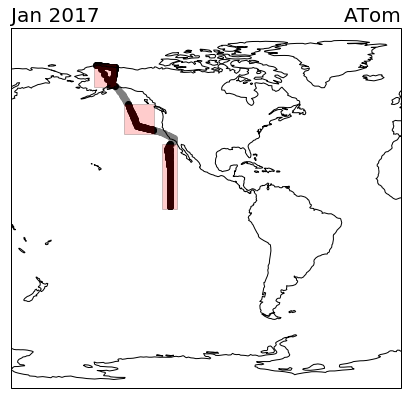

In [13]:
plot_regions(sample_lons, sample_lats, points_within_regions, ukca_regions_corners, -200, -5, -90, 90)

#### Process ATom data

In [14]:
# Convert ATom C2H6, C2H4, C2H2, C3H8, C3H6 to pptvC to match UKCA lumped species, namely C2H6=C2H6+C2H4+C2H2, C3H8=C3H8+C3H6
atom_dswas_c2h6 = atom_dswas['Ethane_WAS']*2 + atom_dswas['Ethene_WAS']*2 + atom_dswas['Ethyne_WAS']*2
atom_dswas_c3h8 = atom_dswas['Propane_WAS']*3 + atom_dswas['Propene_WAS']*3
# Convert xarray dataset with observational data to pandas dataframe
atom_c2h6 = atom_dswas_c2h6.to_dataframe(name='c2h6')
atom_c3h8 = atom_dswas_c3h8.to_dataframe(name='c3h8')
atom_nc4h10 = atom_dswas['n-Butane_WAS'].to_dataframe(name='nc4h10')
atom_ic4h10 = atom_dswas['i-Butane_WAS'].to_dataframe(name='ic4h10')
atom_nc5h12 = atom_dswas['n-Pentane_WAS'].to_dataframe(name='nc5h12')
atom_ic5h12 = atom_dswas['i-Pentane_WAS'].to_dataframe(name='ic5h12')
atom_meono2 = atom_dswas['MeONO2_WAS'].to_dataframe(name='meono2')
atom_sbuono2 = atom_dswas['2-BuONO2_WAS'].to_dataframe(name='sbuono2')
atom_n2peono2 = atom_dswas['2-PenONO2_WAS'].to_dataframe(name='n2peono2')
atom_n3peono2 = atom_dswas['3-PenONO2_WAS'].to_dataframe(name='n3peono2')
atom_ipeono2 = atom_dswas['3-Methyl-2-BuONO2_WAS'].to_dataframe(name='ipeono2')

In [15]:
# Select longitudes and latitudes where ATom data is available
lons_c2h6_notnan = np.where(atom_c2h6.c2h6.isna()==False, sample_lons, atom_c2h6.c2h6)
lats_c2h6_notnan = np.where(atom_c2h6.c2h6.isna()==False, sample_lats, atom_c2h6.c2h6)
lons_c3h8_notnan = np.where(atom_c3h8.c3h8.isna()==False, sample_lons, atom_c3h8.c3h8)
lats_c3h8_notnan = np.where(atom_c3h8.c3h8.isna()==False, sample_lats, atom_c3h8.c3h8)
lons_nc4h10_notnan = np.where(atom_nc4h10.nc4h10.isna()==False, sample_lons, atom_nc4h10.nc4h10)
lats_nc4h10_notnan = np.where(atom_nc4h10.nc4h10.isna()==False, sample_lats, atom_nc4h10.nc4h10)
lons_ic4h10_notnan = np.where(atom_ic4h10.ic4h10.isna()==False, sample_lons, atom_ic4h10.ic4h10)
lats_ic4h10_notnan = np.where(atom_ic4h10.ic4h10.isna()==False, sample_lats, atom_ic4h10.ic4h10)
lons_nc5h12_notnan = np.where(atom_nc5h12.nc5h12.isna()==False, sample_lons, atom_nc5h12.nc5h12)
lats_nc5h12_notnan = np.where(atom_nc5h12.nc5h12.isna()==False, sample_lats, atom_nc5h12.nc5h12)
lons_ic5h12_notnan = np.where(atom_ic5h12.ic5h12.isna()==False, sample_lons, atom_ic5h12.ic5h12)
lats_ic5h12_notnan = np.where(atom_ic5h12.ic5h12.isna()==False, sample_lats, atom_ic5h12.ic5h12)
lons_meono2_notnan = np.where(atom_meono2.meono2.isna()==False, sample_lons, atom_meono2.meono2)
lats_meono2_notnan = np.where(atom_meono2.meono2.isna()==False, sample_lats, atom_meono2.meono2)
lons_sbuono2_notnan = np.where(atom_sbuono2.sbuono2.isna()==False, sample_lons, atom_sbuono2.sbuono2)
lats_sbuono2_notnan = np.where(atom_sbuono2.sbuono2.isna()==False, sample_lats, atom_sbuono2.sbuono2)
lons_n2peono2_notnan = np.where(atom_n2peono2.n2peono2.isna()==False, sample_lons, atom_n2peono2.n2peono2)
lats_n2peono2_notnan = np.where(atom_n2peono2.n2peono2.isna()==False, sample_lats, atom_n2peono2.n2peono2)
lons_n3peono2_notnan = np.where(atom_n3peono2.n3peono2.isna()==False, sample_lons, atom_n3peono2.n3peono2)
lats_n3peono2_notnan = np.where(atom_n3peono2.n3peono2.isna()==False, sample_lats, atom_n3peono2.n3peono2)
lons_ipeono2_notnan = np.where(atom_ipeono2.ipeono2.isna()==False, sample_lons, atom_ipeono2.ipeono2)
lats_ipeono2_notnan = np.where(atom_ipeono2.ipeono2.isna()==False, sample_lats, atom_ipeono2.ipeono2)
lons_notnan = [lons_c2h6_notnan, lons_c3h8_notnan, lons_nc4h10_notnan, lons_ic4h10_notnan, lons_nc5h12_notnan, lons_ic5h12_notnan, 
               lons_meono2_notnan, lons_sbuono2_notnan, lons_n2peono2_notnan, lons_n3peono2_notnan, lons_ipeono2_notnan]
lats_notnan = [lats_c2h6_notnan, lats_c3h8_notnan, lats_nc4h10_notnan, lats_ic4h10_notnan, lats_nc5h12_notnan, lats_ic5h12_notnan, 
               lats_meono2_notnan, lats_sbuono2_notnan, lats_n2peono2_notnan, lats_n3peono2_notnan, lats_ipeono2_notnan]

In [16]:
def plot_regions_by_specie(lons, lats, points_within_regions, ukca_regions_corners, llon, ulon, llat, ulat, specie_name, abbr):
    r1_points_within, r2_points_within, r3_points_within = points_within_regions
    [r1_llon, r1_ulon, r1_llat, r1_ulat] = ukca_regions_corners[0]
    [r2_llon, r2_ulon, r2_llat, r2_ulat] = ukca_regions_corners[1]
    [r3_llon, r3_ulon, r3_llat, r3_ulat] = ukca_regions_corners[2]
    
    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), facecolor='w')
    kwargs_sc = dict(color='k', transform=ccrs.PlateCarree())
    ax.scatter(lons[r1_points_within], lats[r1_points_within], **kwargs_sc)
    ax.scatter(lons[r2_points_within], lats[r2_points_within], **kwargs_sc)
    ax.scatter(lons[r3_points_within], lats[r3_points_within], **kwargs_sc)
    kwargs_patch = dict(facecolor='red', alpha=0.2, edgecolor='k', transform=ccrs.PlateCarree())
    ax.add_patch(mpatches.Rectangle(xy=[r1_llon, r1_llat], width=r1_ulon-r1_llon, height=r1_ulat-r1_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r2_llon, r2_llat], width=r2_ulon-r2_llon, height=r2_ulat-r2_llat, **kwargs_patch))
    ax.add_patch(mpatches.Rectangle(xy=[r3_llon, r3_llat], width=r3_ulon-r3_llon, height=r3_ulat-r3_llat, **kwargs_patch))
    ax.set_title('ATom', loc='center')
    ax.set_title(f'{specie_name}', loc='right')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_extent([llon, ulon, llat, ulat], crs=ccrs.PlateCarree())
    ax.coastlines()
    if savefig:
        if publish:
            fig.savefig(path_to_figs / 'publish' / f'{ukca_run_name}_{compared_common_id}_regions_{abbr}.png', bbox_inches='tight')
        fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_regions_{abbr}.png', bbox_inches='tight')

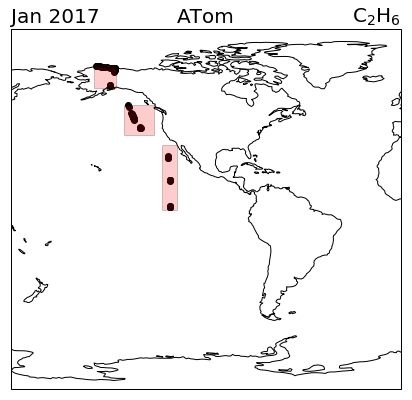

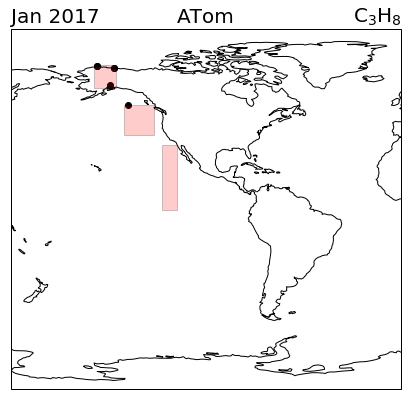

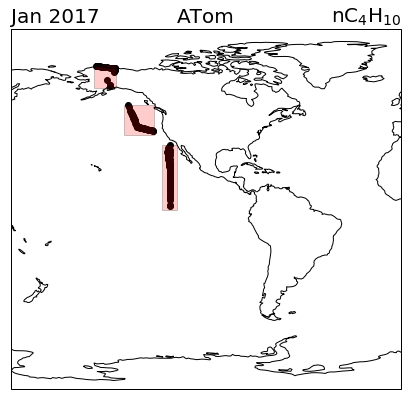

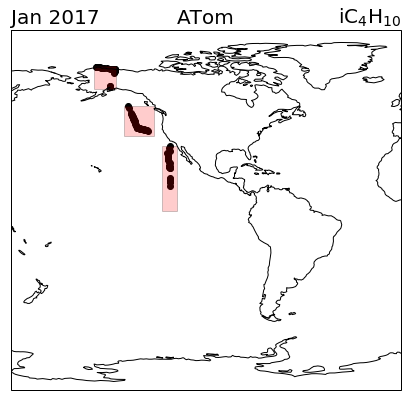

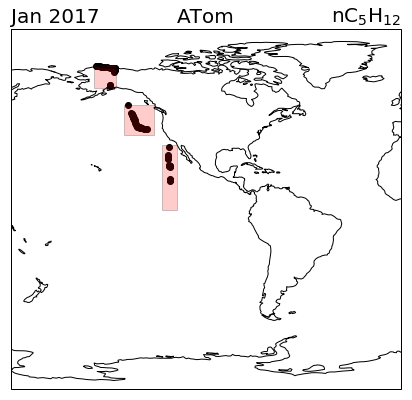

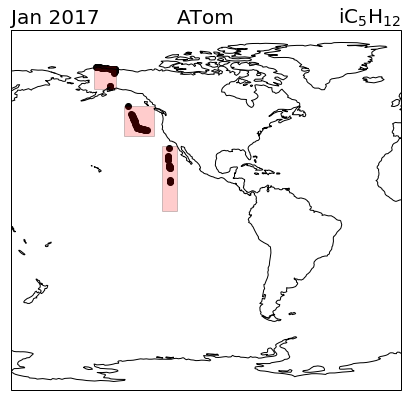

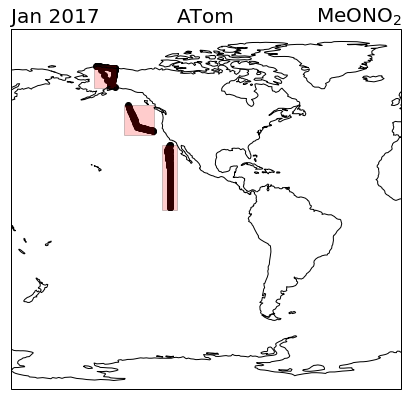

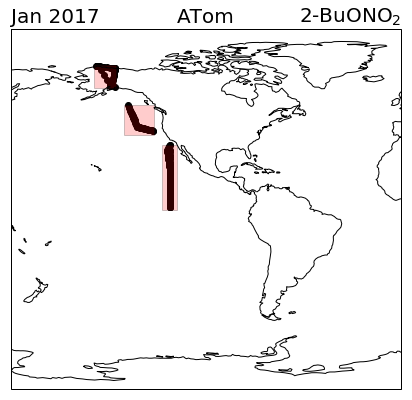

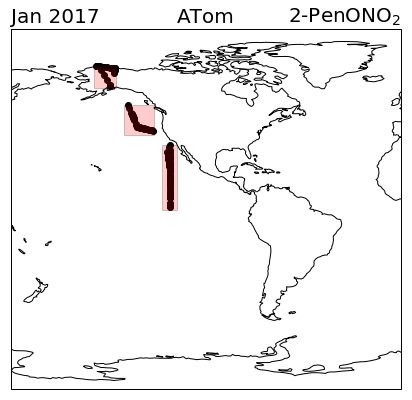

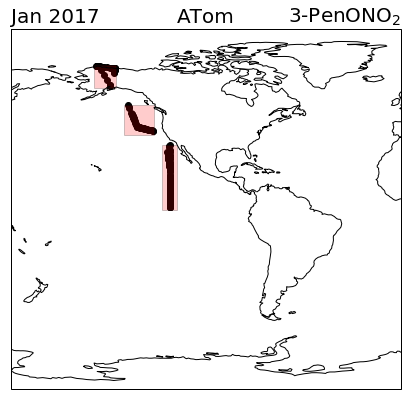

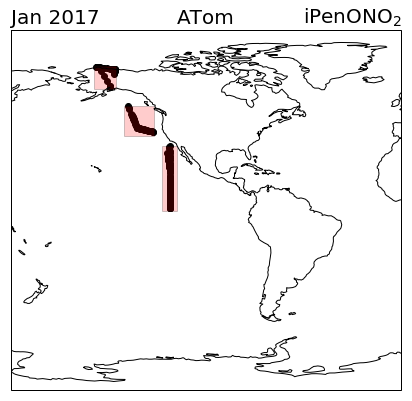

In [17]:
for (specie, specie_dict), lons, lats in zip(species_names_dict.items(), lons_notnan, lats_notnan):
    plot_regions_by_specie(lons, lats, points_within_regions, ukca_regions_corners, -200, -5, -90, 90, specie_dict['latex'], specie_dict['abbr'])

In [18]:
# def plot_ts(atom, alts):
#     fig, ax = plt.subplots()
#     ax.plot(atom, marker='o')
#     ax2 = ax.twinx()
#     ax2.plot(alts, marker='o', color='grey', linestyle='--')

In [19]:
# plot_ts(atom_meono2[r1_points_within].values, atom_dsmms.G_ALT[r1_points_within].data)

In [20]:
# plot_ts(atom_meono2[r2_points_within].values, atom_dsmms.G_ALT[r2_points_within].data)

In [21]:
# plot_ts(atom_meono2[r3_points_within].values, atom_dsmms.G_ALT[r3_points_within].data)

In [22]:
# Choose bins
alt_bins = np.arange(0, 14000, 500)
alt_bin_inds = np.arange(0, len(alt_bins)-1, 1)
alt_bin_mids = np.arange(250, 13500, 500)
alt_r1_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r1_points_within], alt_bins)
alt_r2_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r2_points_within], alt_bins)
alt_r3_bin_inds = np.digitize(atom_dsmms.G_ALT.data[r3_points_within], alt_bins)
alt_regions_bin_inds = [alt_r1_bin_inds, alt_r2_bin_inds, alt_r3_bin_inds]
# Bin observational data
atom2process = [atom_c2h6, atom_c3h8, atom_nc4h10, atom_ic4h10, atom_nc5h12, atom_ic5h12, atom_meono2, atom_sbuono2, atom_n2peono2, atom_n3peono2, atom_ipeono2]
atom_regional_vps = []
for points_within_region, alt_region_bin_inds in zip(points_within_regions, alt_regions_bin_inds):
    specie_dict = {}
    for specie in atom2process:
        stat_dict = {}
        stat_dict['mean'] = specie[points_within_region].groupby(alt_region_bin_inds).mean().reindex(index=alt_bin_inds, fill_value=np.nan)
        stat_dict['std'] = specie[points_within_region].groupby(alt_region_bin_inds).std().reindex(index=alt_bin_inds, fill_value=np.nan)
        specie_dict[specie.columns[0]] = stat_dict
    atom_regional_vps.append(specie_dict)

#### Process UKCA data

In [23]:
# Add coordinate bounds (for calculating area weights)
ukca2process = iris.cube.CubeList([cb_c2h6, cb_c3h8, cb_nc4h10, cb_ic4h10, cb_nc5h12, cb_ic5h12, cb_meono2, cb_sbuono2, cb_n2peono2, cb_n3peono2, cb_ipeono2])
for cube in ukca2process:
    for coord in ['longitude', 'latitude']:
            if not cube.coord(coord).has_bounds():
                cube.coord(coord).guess_bounds()

In [24]:
# Calculate area weights for each region
any_cube = cb_nc4h10
regions = []
for corners in ukca_regions_corners:
    llon, ulon, llat, ulat = corners
    lonlat_constraint = iris.Constraint(longitude=lambda cell: llon <= cell <= ulon, 
                                        latitude=lambda cell: llat <= cell <= ulat)
    any_cube_extr = any_cube.extract(lonlat_constraint)
    weights_cube = any_cube_extr.copy(data=iris.analysis.cartography.area_weights(any_cube_extr))
    weights_cube.rename('area_weights')
    regions.append(
         {'corners': {k: v for k, v in zip(['llon', 'ulon', 'llat', 'ulat'], corners)},
          'area_weights': weights_cube})

In [25]:
# Calculate regional mean vertical profiles and standart deviations
stats = ('mean', 'std_dev')
ukca_regional_vps = []
for region in regions:
    cube_dict = {}
    corners = region['corners']
    lonlat_constraint = iris.Constraint(longitude=lambda cell: corners['llon'] <= cell <= corners['ulon'], 
                                        latitude=lambda cell: corners['llat'] <= cell <= corners['ulat'])    
    for cube in ukca2process.extract(lonlat_constraint):
        stat_dict = {}
        for stat in stats:
            cubelist = iris.cube.CubeList()
            for lbound, ubound in zip(alt_bins[:-1], alt_bins[1:]):
                alt_constraint = iris.Constraint(altitude=lambda cell: lbound < cell <= ubound)              
                cube_extr = cube.extract(alt_constraint)
                if stat == 'mean':
                    kwargs = {'weights': region['area_weights'].extract(alt_constraint).data}
                else:
                    kwargs = {}
                cubelist.append(cube_extr.collapsed(['longitude', 'latitude', 'altitude'], getattr(iris.analysis, stat.upper()), **kwargs))
            stat_dict[stat] = cubelist.merge_cube()
        cube_dict[cube.name()] = stat_dict
    ukca_regional_vps.append(cube_dict)

#### Plot region average vertical profile

In [26]:
def plot_vp(atom_mean, ukca_mean, atom_std, ukca_std, region_name, region_number, specie_name, specie_abbr, specie_ppn, specie_max):
    '''Plot area averaged vertical profile.'''
    fig, ax = plt.subplots(figsize=(7,7), facecolor='w')
    ax.errorbar(atom_mean, alt_bin_mids, xerr=atom_std, color='k', fmt='--o', linewidth=1, elinewidth=0.8, capsize=2)
    ax.errorbar(ukca_mean, alt_bin_mids, xerr=ukca_std, color='r', fmt='--o', linewidth=1, elinewidth=0.8, capsize=2)
    # common
    ax.set_title(f'{specie_name}', loc='right')
    ax.set_title(f'{region_name}', loc='center')
    ax.set_title(f'{atom_date_strt.strftime("%b %Y")}', loc='left')
    ax.set_xlabel(f'{specie_ppn}')
    ax.set_xlim(0, specie_max)
#     try:
#         ax.set_xlim(0, max(np.nanmax(atom_mean+atom_std), np.nanmax(ukca_mean+ukca_std)))
#     except ValueError:
#         pass
    ax.set_ylabel('Altitude, km')
    ax.set_ylim(-200,13500)
    ax.set_yticks(alt_bins)
    ax.set_yticklabels(map(int,(alt_bins/1000)))
    ax.legend(['ATom', f'UKCA'], frameon=False)
    for ytcklbl in ax.yaxis.get_ticklabels()[1::2]:
        ytcklbl.set_visible(False)
    if savefig:
        if publish:
            fig.savefig(path_to_figs / 'publish' / f'{ukca_run_name}_{compared_common_id}_vp_r{region_number}_{specie_abbr}.png', bbox_inches='tight')
        fig.savefig(path_to_figs / f'{ukca_run_name}_{compared_common_id}_vp_r{region_number}_{specie_abbr}.png', bbox_inches='tight')

/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/local/mwe14avu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


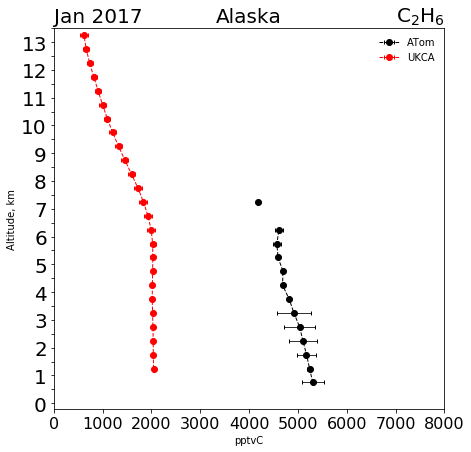

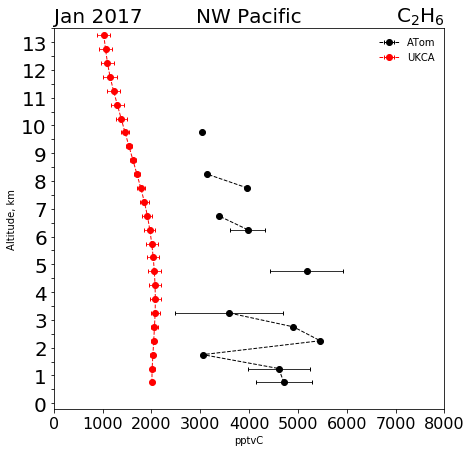

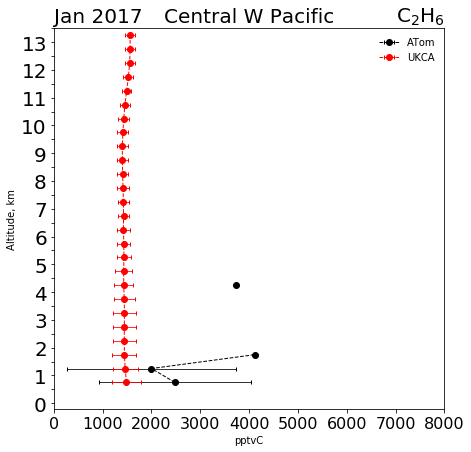

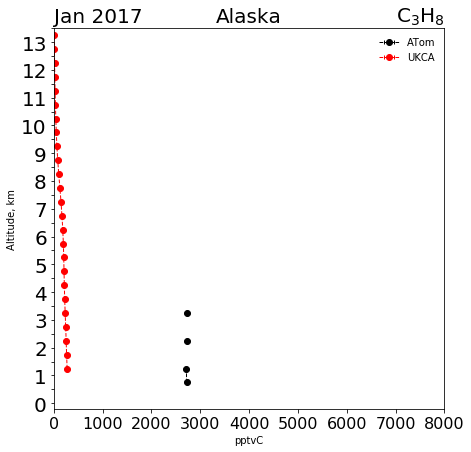

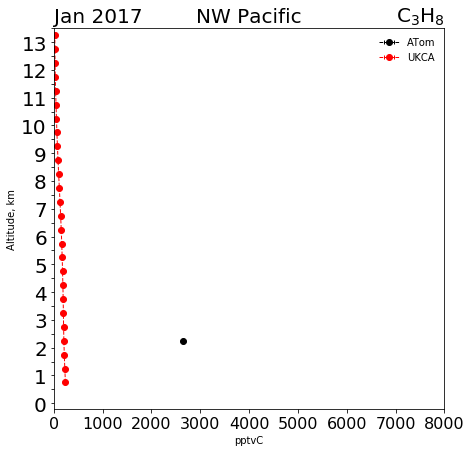

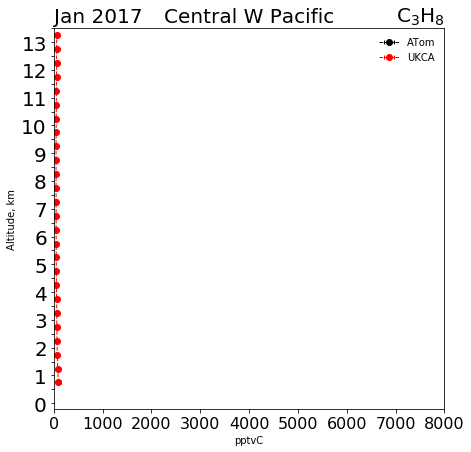

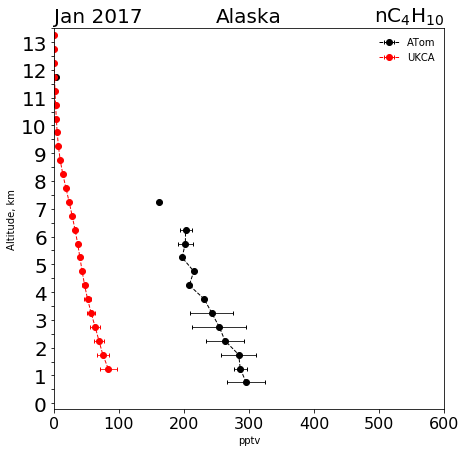

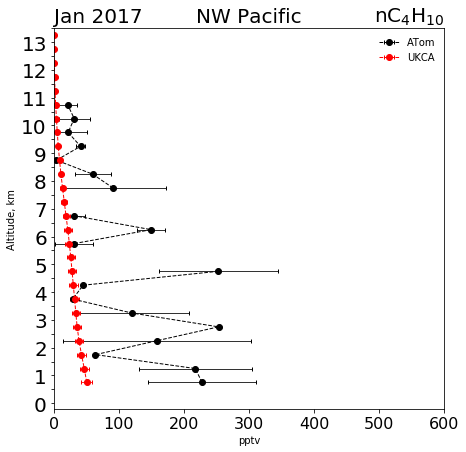

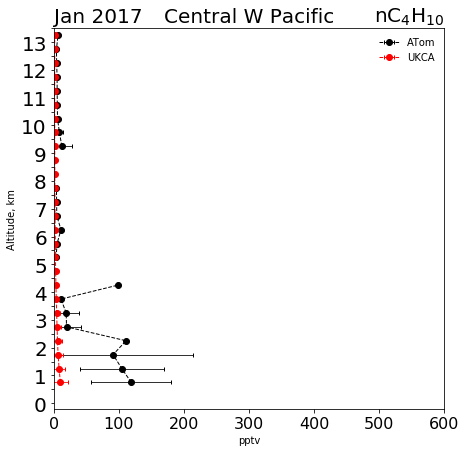

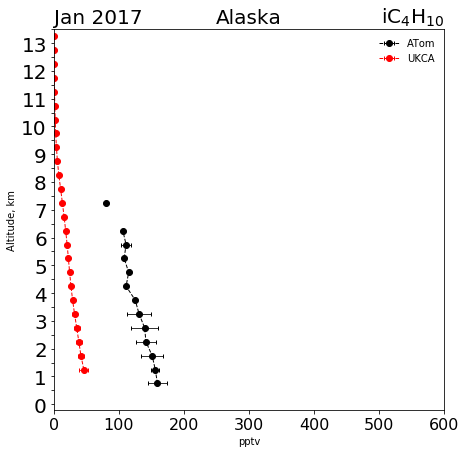

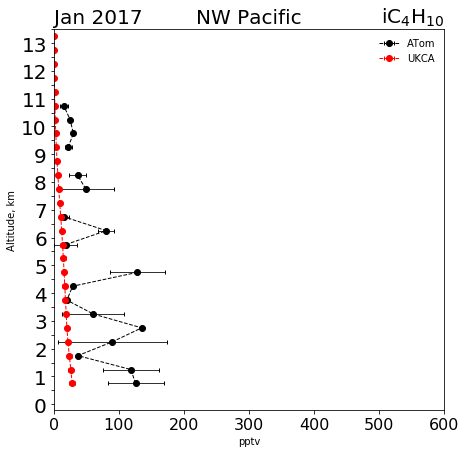

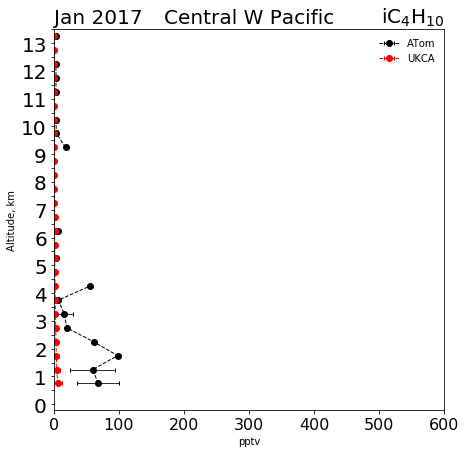

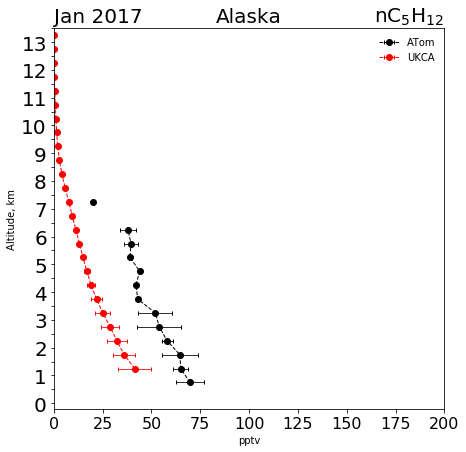

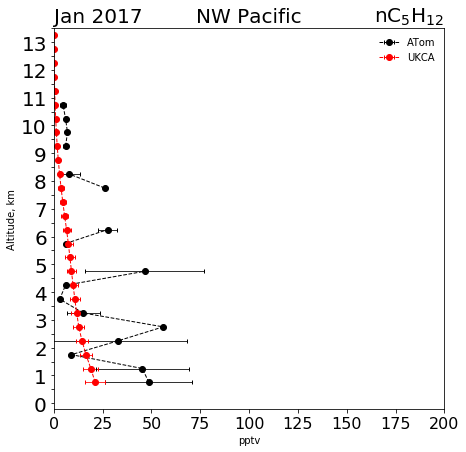

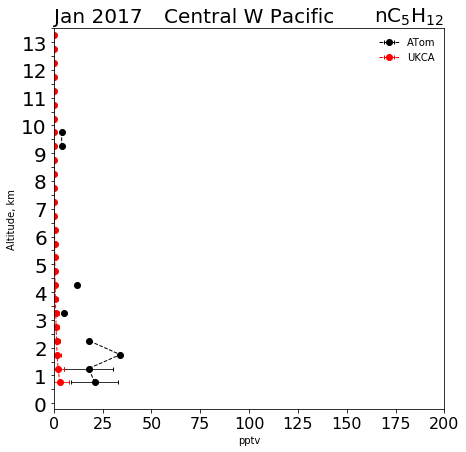

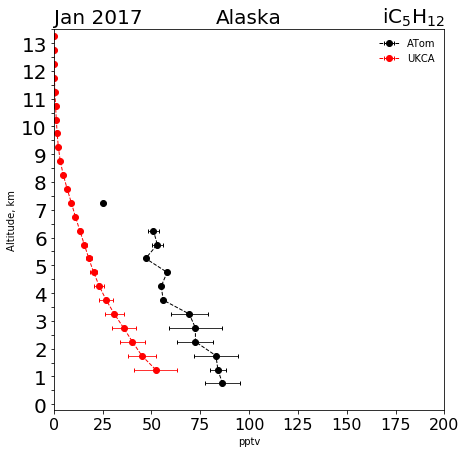

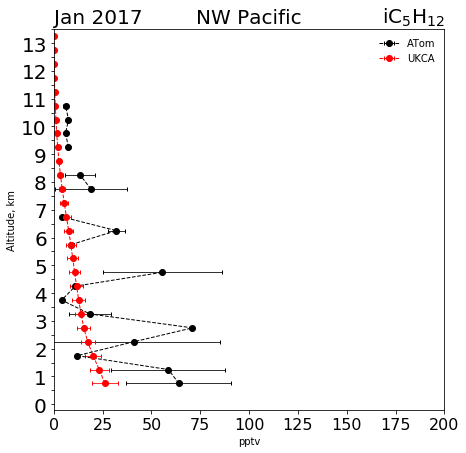

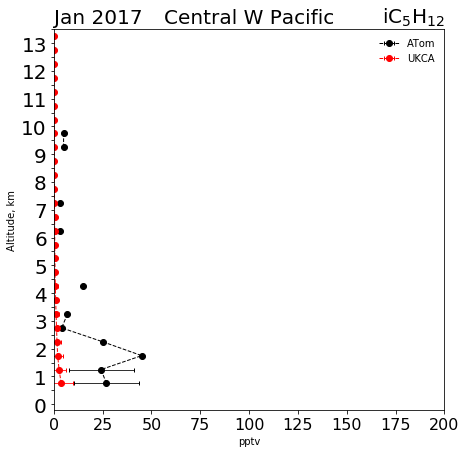

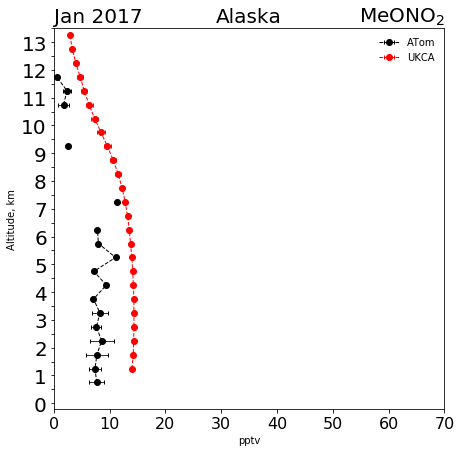

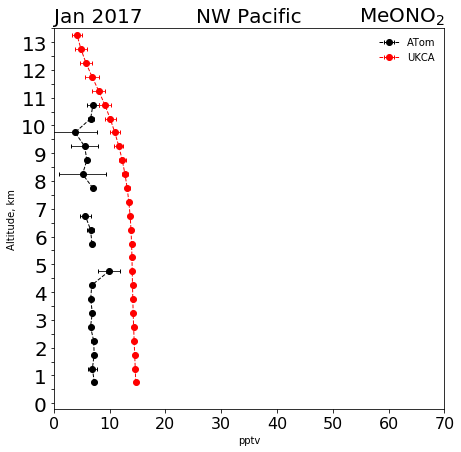

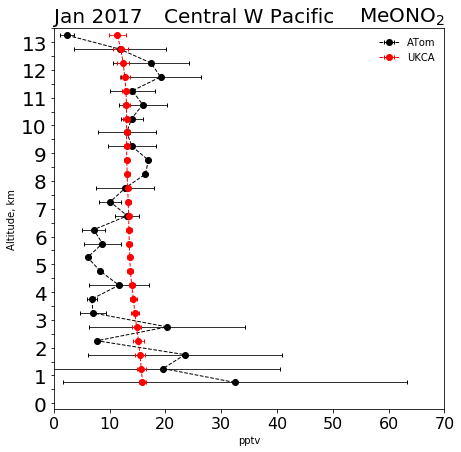

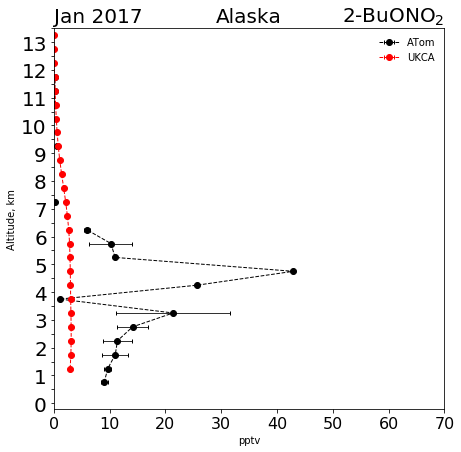

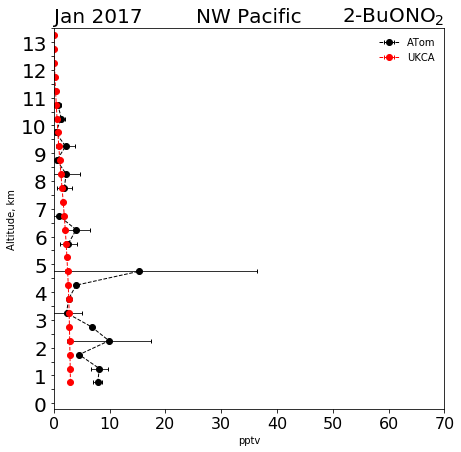

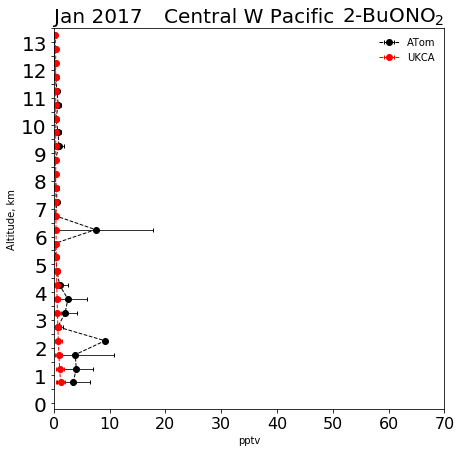

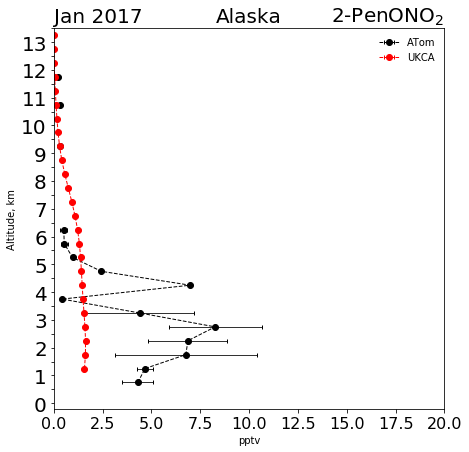

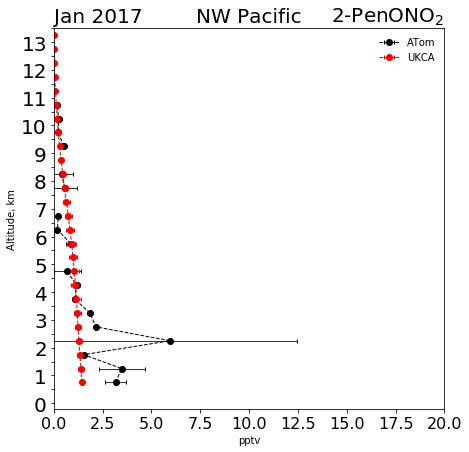

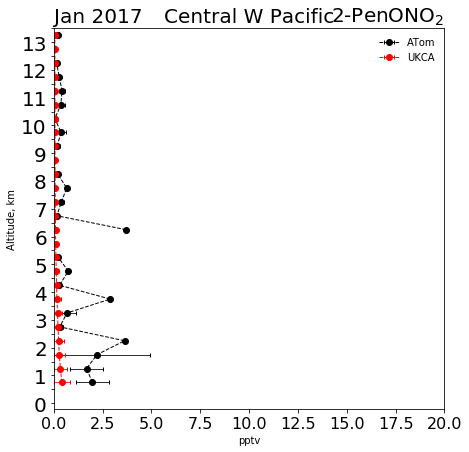

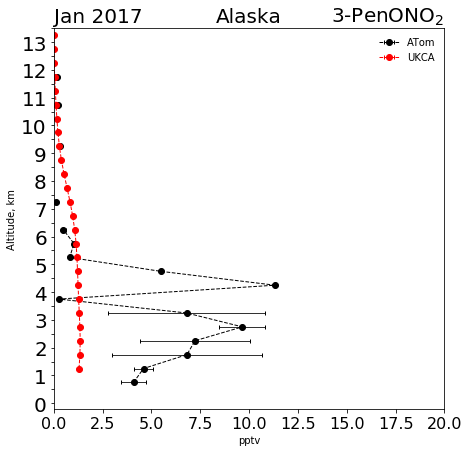

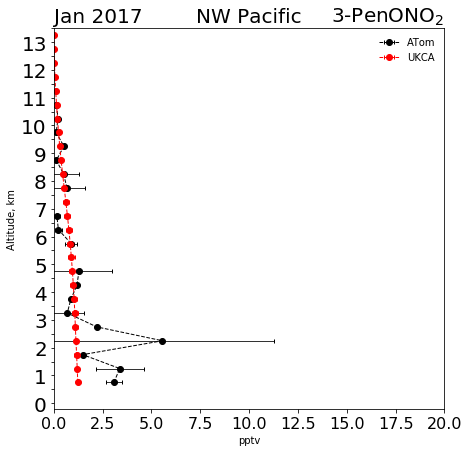

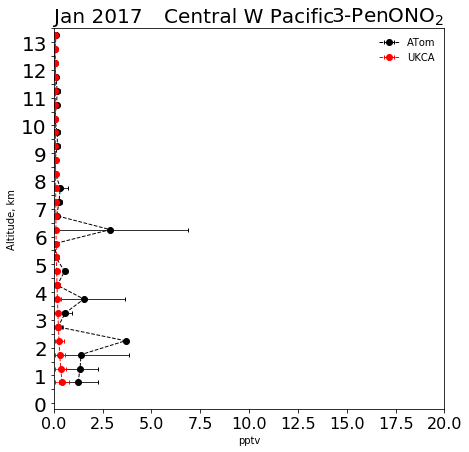

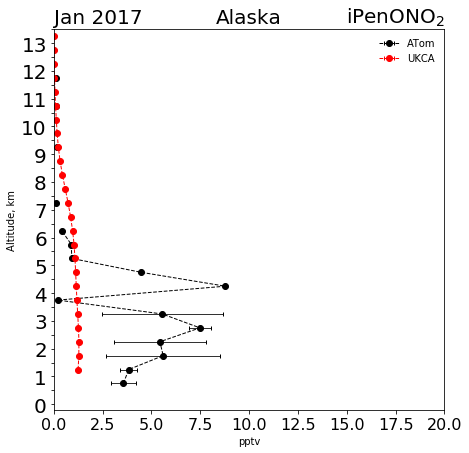

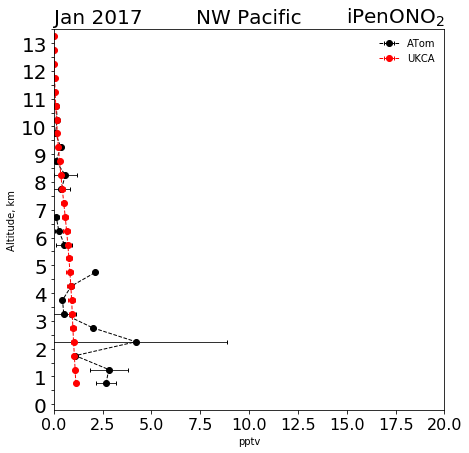

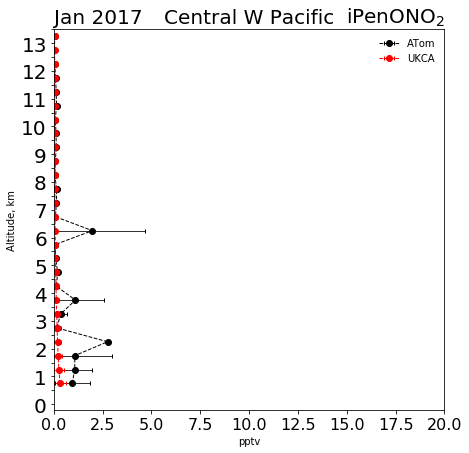

In [27]:
for specie, specie_dict in species_names_dict.items():
    for n, region_name in enumerate(region_names):
        plot_vp(atom_regional_vps[n][specie]['mean'].values, 
                ukca_regional_vps[n][specie]['mean'].data, 
                atom_regional_vps[n][specie]['std'].values, 
                ukca_regional_vps[n][specie]['std_dev'].data, region_name, n+1, specie_dict['latex'], specie_dict['abbr'], specie_dict['ppn'], specie_dict['max'])